## Neural Network From Scratch 

### Dependencies

In [46]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_openml

### Load MNIST Dataset

In [47]:
mnist_dataset = fetch_openml('mnist_784')

dir(mnist_dataset)

['DESCR',
 'categories',
 'data',
 'details',
 'feature_names',
 'frame',
 'target',
 'target_names',
 'url']

In [48]:
mnist_dataset.data

,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,pixel10,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
69995,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
69996,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
69997,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
69998,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [49]:
mnist_dataset.data.shape

(70000, 784)

In [50]:
mnist_dataset.target

0        5
1        0
2        4
3        1
4        9
        ..
69995    2
69996    3
69997    4
69998    5
69999    6
Name: class, Length: 70000, dtype: category
Categories (10, object): ['0', '1', '2', '3', ..., '6', '7', '8', '9']

In [51]:
mnist_dataset.data.isnull().values.any()

False

In [52]:
X = mnist_dataset.data.to_numpy()/255
y = mnist_dataset.target.to_numpy()
y = y.astype(int)

In [53]:
X.shape, y.shape

((70000, 784), (70000,))

### Visualization 

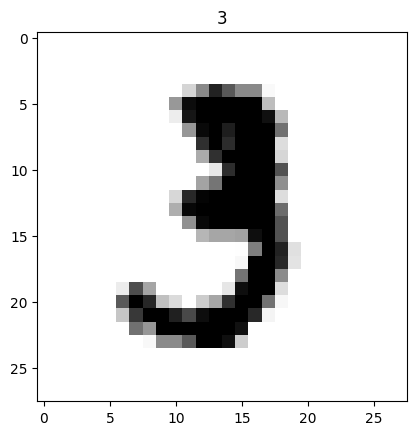

In [54]:
plt.imshow(X[10].reshape((28,28)), cmap='binary')
plt.title(y[10])
plt.show()

### Train Test Split

In [55]:
X_train, X_test = X[:60000], X[60000:]
y_train, y_test = y[:60000], y[60000:]

### Util Functions

In [56]:
def ReLU(x):
    return np.maximum(0, x)

def deriv_ReLU(x):
    return x > 0

def softmax(x):
    max_x = np.max(x, axis=0, keepdims=True)
    exp_x = np.exp(x - max_x)
    return exp_x / np.sum(exp_x, axis=0, keepdims=True)

def get_accuracy(pred, target):
    return np.sum(pred == target) / target.shape[0]

In [57]:
def one_hot_encoding(y):
    one_hot = np.zeros((y.shape[0], 10))
    one_hot[np.arange(y.shape[0]), y] = 1
    return one_hot

### Create Layers

In [58]:
np.random.seed(42)

class Layer:
    def __init__(self,
                 in_features: int,
                 out_features: int):
        
        self.weight = np.random.randn(out_features, in_features)
        self.bias = np.random.randn(out_features, 1)

    def forward(self, x):
        return np.dot(self.weight, x) + self.bias

    def __call__(self, x):
        return self.forward(x)

In [59]:
np.random.seed(42)

class MNISTClassifier:
    def __init__(self, batch_size=32, lr=0.001):
        self.batch_size = batch_size
        self.lr = lr
        
        self.layer_1 = Layer(in_features=784,
                            out_features=15)
        self.layer_2 = Layer(in_features=15,
                            out_features=10)

    def forward(self, x):
        self.z1 = self.layer_1(x.T)
        self.a1 = ReLU(self.z1)
        self.z2 = self.layer_2(self.a1)
        self.a2 = softmax(self.z2)
        
    def backward(self,x,y):
        dz2 = self.a2 - y.T
        self.dw2 = 1/self.batch_size * np.dot(dz2, self.a1.T)
        self.db2 = 1/self.batch_size * np.sum(dz2, axis=1, keepdims=True)

        dz1 = np.dot(self.layer_2.weight.T, dz2) * deriv_ReLU(self.z1)
        self.dw1 = 1/self.batch_size * np.dot(dz1, x)
        self.db1 = 1/self.batch_size * np.sum(dz1, axis=1, keepdims=True)

    def update_params(self):
        self.layer_1.weight -= self.dw1*self.lr
        self.layer_1.bias -= self.db1*self.lr
        self.layer_2.weight -= self.dw2*self.lr
        self.layer_2.bias -= self.db2*self.lr

    def predict(self, X):
        model.forward(X)
        return np.argmax(self.a2, axis=0)

In [60]:
model = MNISTClassifier(lr=0.01)

### Train Function

In [61]:
acc_list = []

def train(model, epochs, batch_size, X, y):
    one_hot_y = one_hot_encoding(y)
    for epoch in range(epochs):
        for i in range(X.shape[0]//batch_size):
            temp_X = X[i*batch_size:i*batch_size+batch_size]
            temp_y = one_hot_y[i*batch_size:i*batch_size+batch_size]
            
            model.forward(temp_X)
            model.backward(temp_X, temp_y)
            model.update_params()

        if epoch % 50 == 0:
            preds = model.predict(X)
            accuracy = get_accuracy(preds, y)
            acc_list.append(accuracy)
            print(f"Epoch: {epoch} | Accuracy: {accuracy: .4f}")

In [62]:
train(model=model, epochs=501, batch_size=600, X=X_train, y=y_train)

Epoch: 0 | Accuracy:  0.5032
Epoch: 50 | Accuracy:  0.8756
Epoch: 100 | Accuracy:  0.8952
Epoch: 150 | Accuracy:  0.9064
Epoch: 200 | Accuracy:  0.9138
Epoch: 250 | Accuracy:  0.9192
Epoch: 300 | Accuracy:  0.9247
Epoch: 350 | Accuracy:  0.9293
Epoch: 400 | Accuracy:  0.9330
Epoch: 450 | Accuracy:  0.9355
Epoch: 500 | Accuracy:  0.9373


In [63]:
pred = model.predict(X_test)
get_accuracy(pred=pred, target=y_test)

0.9321

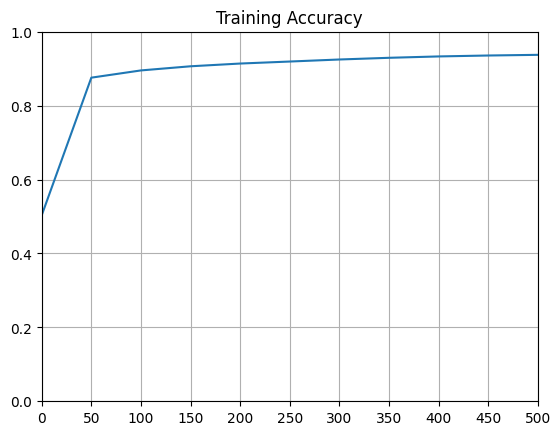

In [75]:
plt.plot(range(0,550,50), acc_list)
plt.title("Training Accuracy")
plt.grid()
plt.xticks(np.arange(0,550,50))
plt.xlim(0,500)
plt.ylim(0,1)
plt.show()